In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=620f9eeea97934fafe2060fc27614a1044eca9f14b654dc912a5862d80042863
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Directory 'patient_photos' created.
Accuracy: 0.8222
Confusion Matrix:
[[42  7]
 [ 9 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        49
           1       0.82      0.78      0.80        41

    accuracy                           0.82        90
   macro avg       0.82      0.82      0.82        90
weighted avg       0.82      0.82      0.82        90

Enter the patient index you want to analyze (0 to 89): 78

Selected Patient's Original Features and Values:
age: 41.0
sex: 1.0
cp: 3.0
trestbps: 112.0
chol: 250.0
fbs: 0.0
restecg: 0.0
thalach: 179.0
exang: 0.0
oldpeak: 0.0
slope: 1.0
ca: 0.0
thal: 3.0
Looking for image at: patient_photos/78.jpg
Image not found for patient 78. Please check the file name and location.


<ipython-input-2-3b7d3e2b2555>:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{feature}: {X_original_test.iloc[instance_idx][i]}")


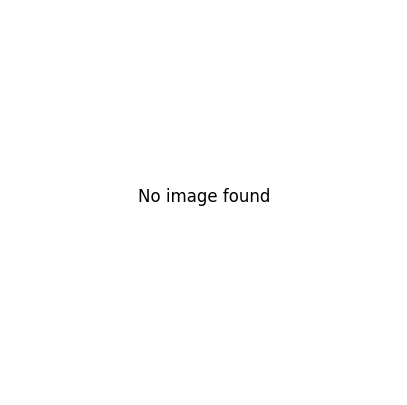

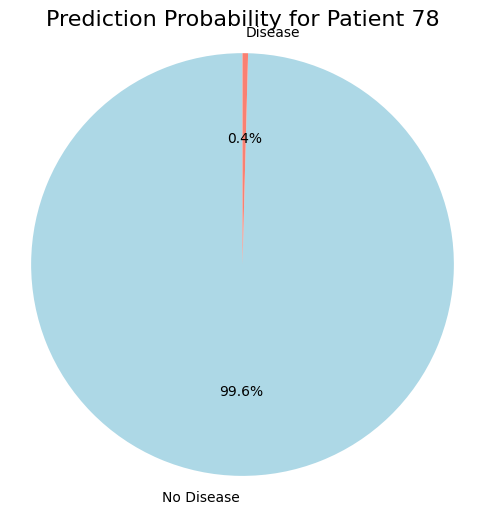

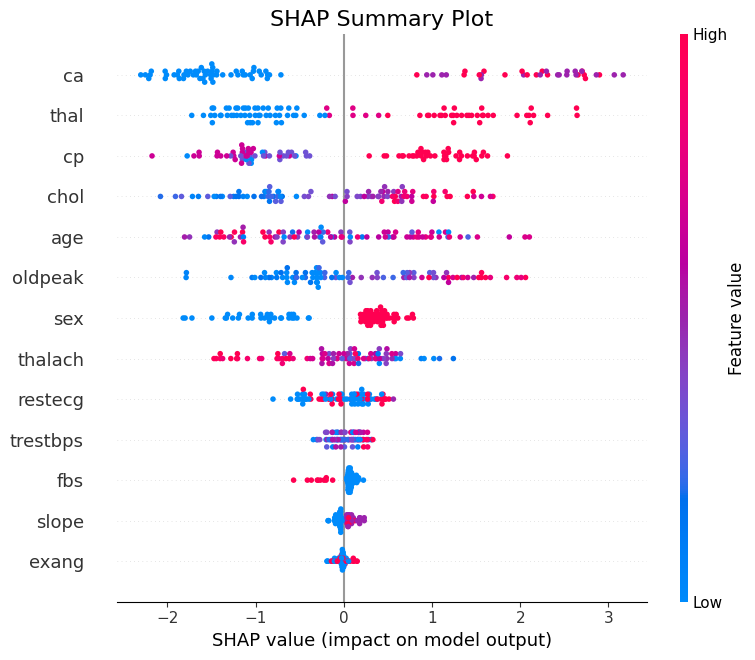

<Figure size 800x600 with 0 Axes>

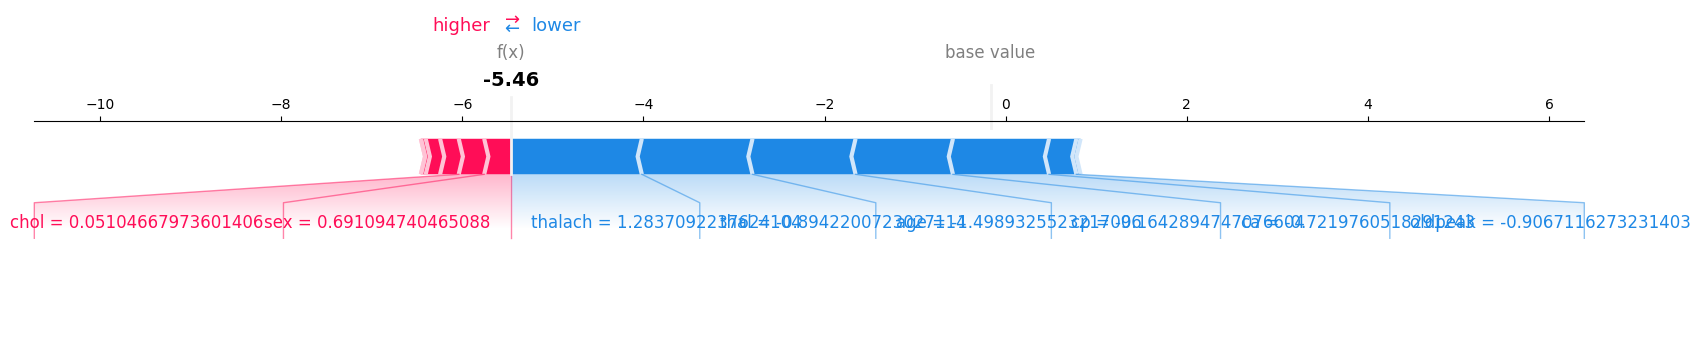

<Figure size 800x600 with 0 Axes>

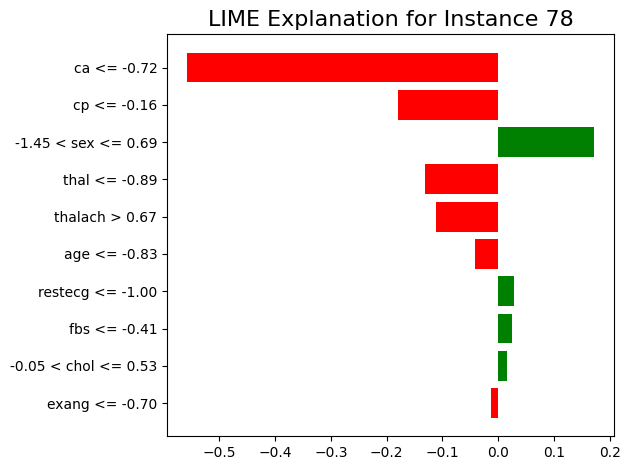


--- Patient Health Summary ---
Patient Age: 41.0
Sex: Male
Chest Pain Type: 3.0
Resting Blood Pressure: 112.0 mm Hg
Cholesterol Level: 250.0 mg/dL
Fasting Blood Sugar > 120 mg/dL: No
Resting Electrocardiographic Results: 0.0
Maximum Heart Rate Achieved: 179.0 bpm
Exercise Induced Angina: No
Oldpeak: 0.0 (depression induced by exercise relative to rest)
Slope of Peak Exercise ST Segment: 1.0
Number of Major Vessels Colored by Fluoroscopy: 0.0
Thalassemia: 3.0
Predicted Health Status: No Disease
Probability of Disease: 0.42%
Probability of No Disease: 99.58%


In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import shap
import lime
from lime import lime_tabular
import matplotlib.pyplot as plt
from PIL import Image
import os

# Create directory for patient photos if it does not exist
if not os.path.exists('patient_photos'):
    os.makedirs('patient_photos')
    print("Directory 'patient_photos' created.")
else:
    print("Directory 'patient_photos' already exists.")

# Step 2: Load Dataset (Using the UCI Heart Disease Dataset)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
                'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=column_names)

# Step 3: Data Preprocessing
data.replace('?', np.nan, inplace=True)  # Handle missing values
data.dropna(inplace=True)

# Convert to numeric
data = data.apply(pd.to_numeric)

# Target: Convert to binary
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

# Features and labels
X = data.drop('target', axis=1)
y = data['target']

# Keep original for display
X_original = X.copy()

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_original_train, X_original_test = train_test_split(X_original, test_size=0.3, random_state=42)

# Step 5: Train XGBoost Classifier
xgb = XGBClassifier(eval_metric='logloss')  # Removed use_label_encoder
xgb.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = xgb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Prompt for user input to specify the instance index
instance_idx = int(input("Enter the patient index you want to analyze (0 to {}): ".format(len(X_original_test) - 1)))

# Display the Selected Patient's Original Feature Data
print("\nSelected Patient's Original Features and Values:")
for i, feature in enumerate(column_names[:-1]):
    print(f"{feature}: {X_original_test.iloc[instance_idx][i]}")

# Step 8: Display the Patient's Photo
image_path = f"patient_photos/{instance_idx}.jpg"
print(f"Looking for image at: {image_path}")

plt.figure(figsize=(5, 5))
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.title(f"Patient {instance_idx}'s Photo", fontsize=16)
except FileNotFoundError:
    print(f"Image not found for patient {instance_idx}. Please check the file name and location.")
    plt.text(0.5, 0.5, "No image found", fontsize=12, ha='center')
    plt.axis('off')
plt.show()

# Step 9: Display Prediction Probabilities
probabilities = xgb.predict_proba(X_test[instance_idx].reshape(1, -1))[0]

plt.figure(figsize=(6, 6))
plt.pie(probabilities, labels=['No Disease', 'Disease'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title(f"Prediction Probability for Patient {instance_idx}", fontsize=16)
plt.axis('equal')
plt.show()

# Step 10: SHAP for Interpretability
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Global SHAP Summary Plot
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_test, feature_names=column_names[:-1], show=False)
plt.title("SHAP Summary Plot", fontsize=16)
plt.tight_layout()
plt.show()

# Local SHAP Force Plot
shap.initjs()
plt.figure(figsize=(8, 6))
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_test[instance_idx],
                feature_names=column_names[:-1], matplotlib=True)
plt.show()

# Step 11: LIME for Local Interpretability
explainer_lime = lime_tabular.LimeTabularExplainer(X_train, feature_names=column_names[:-1],
                                                  class_names=['No Disease', 'Disease'],
                                                  discretize_continuous=True)
exp = explainer_lime.explain_instance(X_test[instance_idx], xgb.predict_proba, num_features=10)

# Display LIME explanation
plt.figure(figsize=(8, 6))
exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {instance_idx}", fontsize=16)
plt.tight_layout()
plt.show()

# Step 12: Final Health Summary
print("\n--- Patient Health Summary ---")
patient_data = X_original_test.iloc[instance_idx]  # Ensure this is an integer index
prediction = "Disease" if probabilities[1] > 0.5 else "No Disease"
print(f"Patient Age: {patient_data['age']}")
print(f"Sex: {'Male' if patient_data['sex'] == 1 else 'Female'}")
print(f"Chest Pain Type: {patient_data['cp']}")
print(f"Resting Blood Pressure: {patient_data['trestbps']} mm Hg")
print(f"Cholesterol Level: {patient_data['chol']} mg/dL")
print(f"Fasting Blood Sugar > 120 mg/dL: {'Yes' if patient_data['fbs'] == 1 else 'No'}")
print(f"Resting Electrocardiographic Results: {patient_data['restecg']}")
print(f"Maximum Heart Rate Achieved: {patient_data['thalach']} bpm")
print(f"Exercise Induced Angina: {'Yes' if patient_data['exang'] == 1 else 'No'}")
print(f"Oldpeak: {patient_data['oldpeak']} (depression induced by exercise relative to rest)")
print(f"Slope of Peak Exercise ST Segment: {patient_data['slope']}")
print(f"Number of Major Vessels Colored by Fluoroscopy: {patient_data['ca']}")
print(f"Thalassemia: {patient_data['thal']}")
print(f"Predicted Health Status: {prediction}")
print(f"Probability of Disease: {probabilities[1]*100:.2f}%")
print(f"Probability of No Disease: {probabilities[0]*100:.2f}%")

# Display insight based on SHAP values
shap_value_insights = np.abs(shap_values[instance_idx])  # Ensure you have the correct SHAP values for the instance
important_indices = np.argsort(shap_value_insights)[-3:]  #
